# Introduction

Code adapted from: https://github.com/DmitryUlyanov/deep-image-prior/blob/master/inpainting.ipynb   


**v7**     
1. LR finder with Encoder-Decoder

**v6**     
1. LR finder with UNet
1. The conv definitin in common.py was modified to apply Xavier initialization to ONLY to the weights (not biases)

**v5**     
1. UNet   

**v4**     
1. Cyclic learning rate   

**v3**     
1. Include learning rate annealing every 300 epochs (set annealing=**True** in optimize2).    

**v2**     
1. We save the output for each epoch only if the loss is lower   
    1. This required a modification in **optimize2** (previously named optimize)   
1. We optionally save the output if the loss is lower, and only after the 500th iteration   
    1. We moved the **plot_for_gif** function inside the **optimize2** function 

**v1**     
1. The following files in the deep image prior library are modified:
    1. utils.common_utils.py: **optimize** now returns loss   
    1. utils.common_utils.py: **plot_image_grid** plots viridis without interpolation
1. **To do:** Save the output with the lowest loss not the one at the k-iteration

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
# %matplotlib inline

import os
import numpy as np
import scipy.sparse as sparse
from models.resnet import ResNet
from models.unet import UNet
from models.skip3D import skip
import torch
import torch.optim

from utils.inpainting_utils3D import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [2]:
torch.cuda.set_device(0)

In [3]:
import imageio
from matplotlib import rcParams
from copy import copy
from scipy import ndimage
import time
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
from tqdm import tqdm_notebook
from skimage import measure, morphology
from itertools import groupby, count

In [4]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Functions

In [5]:
def set_all_rcParams(true_or_false):
    rcParams['ytick.left']=true_or_false
    rcParams['ytick.right']=true_or_false
    rcParams['xtick.top']=true_or_false
    rcParams['xtick.bottom']=true_or_false
    rcParams['ytick.labelleft'] = true_or_false
    rcParams['ytick.labelright'] = true_or_false
    rcParams['xtick.labeltop'] = true_or_false
    rcParams['xtick.labelbottom'] = true_or_false

In [6]:
def plot_for_gif(image_to_save,num_iter, i):
    fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[8, 1]}, figsize=(14,10))
    ax[0].imshow(image_to_save, cmap='viridis')
    ax[0].axis('off')
    ax[1].axvline(x=.5, c='k')
    ax[1].scatter(.5, i, c='k')
    ax[1].set_ylim([num_iter, 0])
    ax[1].yaxis.tick_right()
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    # ax[1].xticks([], [])
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["bottom"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.subplots_adjust(wspace=.04, hspace=0)
    plt.savefig(f'{path_img_dest}images before gifs/iter {i:5d}.jpeg',
                bbox_inches = 'tight',pad_inches = 0)
    plt.close(fig)
    #return fig

In [7]:
# # # # To create folders for new experiment version
# os.chdir('dip results all 8')
# for i in ['arrays', 'differences', 'gifs', 'images before gifs']:
#     os.makedirs(i)
# os.chdir('arrays')
# for i in ['last', 'orig']:
#     os.makedirs(i)
# os.chdir('../..')

In [8]:
nsh=np.shape

In [9]:
def save_original(image_to_save, id_name, name_extension, error_final=-1):
    name_extension = str(name_extension)
    fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[8, 1]}, figsize=(14,10))
    ax[0].imshow(image_to_save, cmap='viridis')
    ax[0].axis('off')
    ax[1].axvline(x=.5, c='k')
    ax[1].set_ylim([num_iter, 0])
    ax[1].yaxis.tick_right()
    ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["bottom"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.subplots_adjust(wspace=.04, hspace=0)
    if error_final==-1: # for original
        fig.savefig(f'{path_img_dest}gifs/dip {id_name} {name_extension}.jpeg',
                    bbox_inches = 'tight',pad_inches = 0)
    else:
        fig.savefig(f'{path_img_dest}gifs/dip {id_name} {name_extension} {error_final:05d}.jpeg',
                    bbox_inches = 'tight',pad_inches = 0)
    plt.close(fig)

In [10]:
def plot_3d(image, threshold=-300, alpha=.70, fig_size=10):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, x,y = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(fig_size, fig_size))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [11]:
def read_slices(new_name):
    """Read slices of lung, mask outside lungs and nodule, mask nodule, mask outside"""
    idname = new_name.split('_')[0]
    file_lung = np.load(f'{path_data}lungs/{new_name}')
    file_mask = np.load(f'{path_data}masks/{new_name}')
    file_nodule = np.load(f'{path_data}nodule to focus on/{new_name}')
    file_outside  = np.load(f'{path_data}outside lungs mask/{new_name}')
    lungs_slice = file_lung.f.arr_0
    mask_slice = file_mask.f.arr_0
    nodule = file_nodule.f.arr_0
    outside_lungs = file_outside.f.arr_0
    return lungs_slice, mask_slice, nodule, outside_lungs

In [12]:
def make3d_from_sparse(path):
    slices_all = os.listdir(path)
    slices_all = np.sort(slices_all)
    for idx, i in enumerate(slices_all):
        sparse_matrix = sparse.load_npz(f'{path}{i}')
        array2d = np.asarray(sparse_matrix.todense())
        if idx == 0: 
            scan3d = array2d
            continue
        scan3d = np.dstack([scan3d,array2d])
    return scan3d

In [13]:
def make_images_right_size3D(lungs_slice, mask_slice, mask_maxvol_and_lungs_small, outside_lungs):
    """Make the images the right size 
    The encoder-decoder has five blocks (the one initially evalluated), 
    therefore, each side has to be divisible by a factor of 32 (2^5)"""
    print('formating shape')
    factor = 32
    pad_dim_0 = factor - np.shape(lungs_slice)[0] % factor
    pad_dim_1 = factor - np.shape(lungs_slice)[1] % factor
    pad_dim_2 = factor - np.shape(lungs_slice)[2] % factor

    #mask_slice = 1 - mask_slice

    lungs_slice = np.pad(lungs_slice, ((0,pad_dim_0), (0,pad_dim_1), (0, pad_dim_2)), mode='constant')
    mask_slice = np.pad(mask_slice, ((0,pad_dim_0), (0,pad_dim_1), (0, pad_dim_2)), mode='constant')
    mask_max =  np.pad(mask_maxvol_and_lungs_small, ((0,pad_dim_0), (0,pad_dim_1), (0, pad_dim_2)), mode='constant')
    outside_lungs = np.pad(outside_lungs, ((0,pad_dim_0), (0,pad_dim_1), (0, pad_dim_2)), mode='constant', constant_values=0)

    # Normalize
    lungs_slice = (lungs_slice - np.min(lungs_slice))/(np.max(lungs_slice)-np.min(lungs_slice))
    
    # Add dimensions
    lungs_slice = np.expand_dims(lungs_slice, 0)
    mask_slice = np.expand_dims(mask_slice, 0)
    outside_lungs = np.expand_dims(outside_lungs, 0)
    mask_max = np.expand_dims(mask_max, 0)
    

    img_np = lungs_slice
    img_mask_np = mask_max
    return img_np, img_mask_np, outside_lungs

In [14]:
def read_slices3D(idnumber):
    ii_ids = f'LIDC-IDRI-{idnumber:04d}'
    print(f'reading scan {ii_ids}')
    vol = make3d_from_sparse(f'{path_data}{ii_ids}/scans/')
    mask = make3d_from_sparse(f'{path_data}{ii_ids}/consensus_masks/')
    mask_maxvol = make3d_from_sparse(f'{path_data}{ii_ids}/maxvol_masks/')
    mask_lungs = make3d_from_sparse(f'{path_data}{ii_ids}/lung_masks/')  
    # rearrange axes to slices first
    vol = np.swapaxes(vol,1,2)
    vol = np.swapaxes(vol,0,1)
    mask = np.swapaxes(mask,1,2)
    mask = np.swapaxes(mask,0,1)
    mask_maxvol = np.swapaxes(mask_maxvol,1,2)
    mask_maxvol = np.swapaxes(mask_maxvol,0,1)
    mask_lungs = np.swapaxes(mask_lungs,1,2)
    mask_lungs = np.swapaxes(mask_lungs,0,1)
    # Find the minimum box that contain the lungs 
    min_box = np.where(vol!=0)
    min_box_c = min_box[0]
    min_box_x = min_box[1]
    min_box_y = min_box[2]
    # Apply the minimum box to the vol and masks
    vol_small = vol[np.min(min_box_c):np.max(min_box_c),np.min(min_box_x):np.max(min_box_x),np.min(min_box_y):np.max(min_box_y)]
    mask_small = mask[np.min(min_box_c):np.max(min_box_c),np.min(min_box_x):np.max(min_box_x),np.min(min_box_y):np.max(min_box_y)]
    mask_maxvol_small = mask_maxvol[np.min(min_box_c):np.max(min_box_c),np.min(min_box_x):np.max(min_box_x),np.min(min_box_y):np.max(min_box_y)]
    mask_lungs_small = mask_lungs[np.min(min_box_c):np.max(min_box_c),np.min(min_box_x):np.max(min_box_x),np.min(min_box_y):np.max(min_box_y)] 
    # Get the mask_maxvol_small and the mask_lungs_small together
    mask_maxvol_and_lungs = mask_lungs_small - mask_maxvol_small
    return vol_small, mask_maxvol_small, mask_maxvol_and_lungs, mask_lungs_small

In [15]:
path_data = f'/data/OMM/Datasets/LIDC_other_formats/LIDC_preprocessed_3D v2/'
ids = os.listdir(path_data)
ids = np.sort(ids)

In [16]:
vol_small, mask_maxvol_small, mask_maxvol_and_lungs_small, mask_lungs_small = read_slices3D(12)
img_np, img_mask_np, outside_lungs = make_images_right_size3D(vol_small, mask_maxvol_small, mask_maxvol_and_lungs_small, mask_lungs_small)

reading scan LIDC-IDRI-0012
formating shape


In [17]:
nsh(img_np), nsh(img_mask_np), nsh(outside_lungs)

((1, 320, 224, 288), (1, 320, 224, 288), (1, 320, 224, 288))

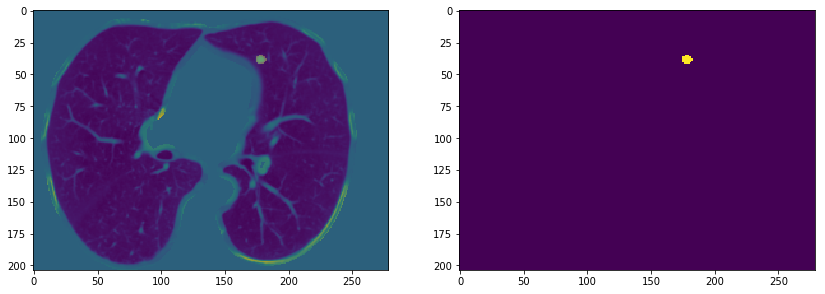

In [18]:
one_slice = 160
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].imshow(vol_small[one_slice])
ax[0].imshow(mask_maxvol_small[one_slice], alpha=.3)
ax[1].imshow(mask_maxvol_small[one_slice])

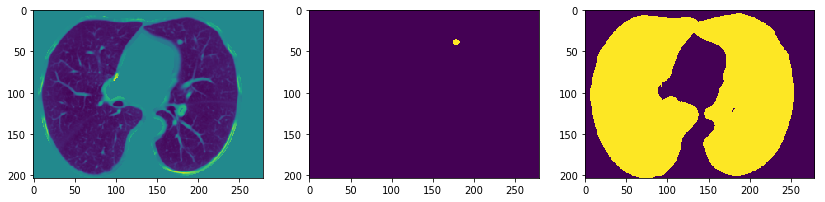

In [19]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].imshow(vol_small[one_slice])
ax[1].imshow(mask_maxvol_small[one_slice])
ax[2].imshow(mask_lungs_small[one_slice])

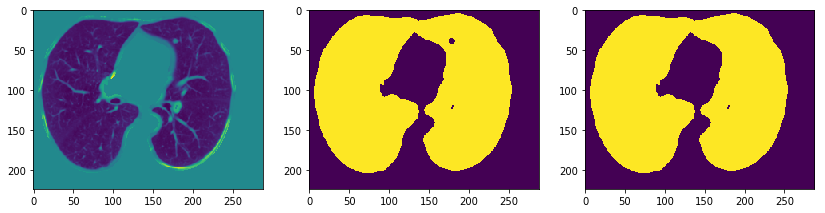

In [20]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].imshow(img_np[0][one_slice])
ax[1].imshow(img_mask_np[0][one_slice])
ax[2].imshow(outside_lungs[0][one_slice])

In [21]:
red32 = 32*5
_, s1, s2, s3 = nsh(img_np)
img_np = img_np[:,:s1-red32, :s2-red32, :s3-red32]
img_mask_np = img_mask_np[:,:s1-red32, :s2-red32, :s3-red32]
outside_lungs = outside_lungs[:,:s1-red32, :s2-red32, :s3-red32]

In [22]:
nsh(img_np), nsh(img_mask_np), nsh(outside_lungs)

((1, 160, 64, 128), (1, 160, 64, 128), (1, 160, 64, 128))

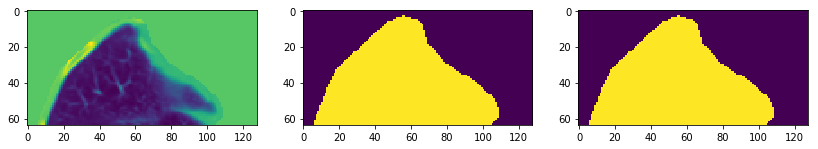

In [23]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].imshow(img_np[0][80])
ax[1].imshow(img_mask_np[0][80])
ax[2].imshow(outside_lungs[0][80])

In [24]:
def closure():
    
    global i
    
    images_all = []
#     image_to_save= [] 
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
#     print(np.shape(out))
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    #if  PLOT and i % show_every == 0:
    if  PLOT:
        out_np = torch_to_np(out)
        if np.shape(out_np)[0] == 1:
            image_to_save = out_np[0]
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1) # DEL original fun
        #plot_for_gif(image_to_save, num_iter, i) # DEL save images to make gif
        images_all.append(image_to_save)
        
    i += 1
    
#     if  PLOT and i % show_every == 0: image_generated = image_to_save
#     else: image_generated = []
    
    return total_loss, images_all

In [25]:
# path_data = f'/data/OMM/Datasets/LIDC_other_formats/LIDC slices inpainting/'
path_img_dest = 'dip results all 8/'

In [26]:
# NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet
pad = 'zero' # 'zero' OMM it was reflection
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = 1
LR = 0.000001 
num_iter = 10001
param_noise = False
show_every = 500
figsize = 5
reg_noise_std = 0.00

In [27]:
LR = 1e-8
LRs = []
for i in range(1000):
    LR *= 1.1
    if LR >= 1: break
    LRs.append(LR)

193


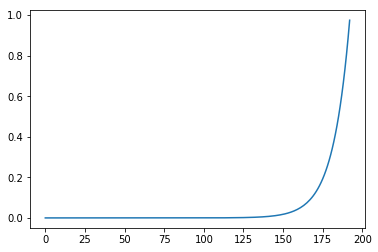

In [28]:
print(len(LRs))
plt.plot(LRs)

In [ ]:
LR = 1e-8
files=[12]
#for idx, new_name in tqdm_notebook(enumerate(files), total=len(files)):
for idx, new_name in tqdm_notebook(enumerate(files), total=len(files)):
    start = time.time()
#     if idx<878: continue
    print(f'sample = {idx}')
#     idname=new_name[:-4]
    
    restart = True
    restart_i = 0
    
    lungs_slice, mask_slice, nodule, outside_lungs = read_slices3D(new_name)
    
    img_np, img_mask_np, outside_lungs = make_images_right_size3D(lungs_slice, mask_slice, nodule, outside_lungs)
    
    red32 = 32*5
    _, s1, s2, s3 = nsh(img_np)
    img_np = img_np[:,:s1-red32, :s2-red32, :s3-red32]
    img_mask_np = img_mask_np[:,:s1-red32, :s2-red32, :s3-red32]
    outside_lungs = outside_lungs[:,:s1-red32, :s2-red32, :s3-red32]
    
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)
    
    # LR finder

    net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5,
           num_channels_up   = [128] * 5,
           num_channels_skip = [0] * 5,
           upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    net = net.type(dtype)
    
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    
    
    mse_error = []
    start = time.time()
    i = 0
    
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    p = get_params(OPT_OVER, net, net_input)

    mse_error, images_generated_all, best_iter = optimize3(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, restart, annealing=False, lr_finder_flag=True)
    mse_error_lr = [i.detach().cpu().numpy() for i in mse_error]
    
    del net
    
    # Find the longest sequence of slope < -1e-4
    loss_going_down = np.where(np.diff(mse_error) < -1e-4)
    loss_going_down = list(loss_going_down[0] + 1) 
    c = count()
    val = max((list(g) for _, g in groupby(loss_going_down, lambda x: x-next(c))), key=len)
    val = list(val)
    LR = LRs[val[-3]] # this is the new LR
    
    # Training
    while restart == True:
        
        print(f'training initialization {restart_i} with LR = {LR:.5f}')
        restart_i += 1
        
        #lungs_slice, mask_slice, nodule, outside_lungs = read_slices(new_name)
        #img_np, img_mask_np, outside_lungs = make_images_right_size(lungs_slice, mask_slice, nodule, outside_lungs)

        # Loss
        mse = torch.nn.MSELoss().type(dtype)
        img_var = np_to_torch(img_np).type(dtype)
        mask_var = np_to_torch(img_mask_np).type(dtype)

        net = skip(input_depth, img_np.shape[0], num_channels_down = [128] * 5,
                   num_channels_up   = [128] * 5, num_channels_skip = [0] * 5, 
                   upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, 
                   filter_size_down=3, need_sigmoid=True, need_bias=True, pad=pad, 
                   act_fun='LeakyReLU').type(dtype)
        net = net.type(dtype)        
        net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
        
        path_trained_model = f'{path_img_dest}models/v6_Unet_init_sample_{idx}.pt'
        #torch.save(net.state_dict(), path_trained_model)

        mse_error = []
        start = time.time()
        i = 0
        net_input_saved = net_input.detach().clone()
        noise = net_input.detach().clone()
        p = get_params(OPT_OVER, net, net_input)
        mse_error, images_generated_all, best_iter, restart = optimize4(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, restart, annealing=True, lr_finder_flag=False)
    
#     factor = 1e11
#     mse_error_last = mse_error[-1].detach().cpu().numpy()
#     error_final = int((mse_error_last * factor) / np.sum(img_mask_np[0]))

        if restart_i % 10 == 0: # reduce lr if the network is not learning with the initializations
            LR /= 1.1
        if restart_i == 30: # if the network cannot be trained continue (might not act on for loop!!)
            continue
    del net      
    #save_original(img_np[0],idname, 'orig')
    image_last = images_generated_all[-1][0] * (1-outside_lungs[0])
    image_orig = img_np[0] * (1-outside_lungs[0])
    best_iter = f'{best_iter:4d}'
    #save_original(image_last,idname, best_iter)
    
    np.save(f'{path_img_dest}arrays/last/last {idname}',image_last)
    np.save(f'{path_img_dest}arrays/orig/orig {idname}',img_np[0])
    stop = time.time()
    print(f'{start-stop:.3f} s')
    print('')

sample = 0
reading scan LIDC-IDRI-0012
formating shape
Finding LR


/home/om18/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


training initialization 0 with LR = 0.00000


In [ ]:
plt.plot(mse_error_lr)

In [ ]:
mse_error_7 = mse_error
plt.semilogy(mse_error_1, label='1')
plt.semilogy(mse_error_2, label='2')
plt.semilogy(mse_error_3, label='3')
plt.semilogy(mse_error_4, label='4')
plt.semilogy(mse_error_5, label='5')
plt.semilogy(mse_error_6, label='6')
plt.semilogy(mse_error_7, label='7')
plt.ylim([1e-6, 1e-1])
plt.legend()

In [ ]:
mse_error_3 = mse_error
plt.semilogy(mse_error_1)
plt.semilogy(mse_error_2)
plt.semilogy(mse_error_3)
plt.ylim([1e-6, 1e-1])

In [ ]:
mse_error_np = [float(i.detach().cpu().numpy()) for i in mse_error]

In [ ]:
plt.figure(figsize=(14,10))
plt.imshow(images_generated_all[-1][0])

In [ ]:
mse_error_1 = mse_error_np
plt.semilogy(mse_error_1)
plt.ylim([1e-5, 1e-1])

In [ ]:
# mse_3_2 = mse_error
plt.semilogy(mse_3_2)
plt.semilogy(mse_3, alpha=.3)

In [ ]:
# using LR = LRs[val[-3]]
# 0.00058, 0.00004
# using LR = LRs[val[-2]]
# 0.00071, 0.00002

In [ ]:
print(f'{LR:.5f}, {mse_error[-1].detach().cpu().numpy():.5f}')

In [ ]:
print(len(LRs))
plt.semilogx(LRs, mse_error)

In [ ]:
loss_going_down = np.where(np.diff(mse_error) < -1e-4)
loss_going_down = list(loss_going_down[0] + 1) 
print(loss_going_down)
c = count()
val = max((list(g) for _, g in groupby(loss_going_down, lambda x: x-next(c))), key=len)
val = list(val)
print('')
print(val)

In [ ]:
mse_error_np = [float(i.detach().cpu().numpy()) for i in mse_error]

In [ ]:
offset = 0
plt.semilogx(LRs, mse_error_np)
plt.semilogx(LRs[val[0] + offset:val[-1] + offset], 
             mse_error_np[val[0] + offset:val[-1] + offset],'r')
plt.scatter(LRs[val[-2]],mse_error_np[val[-2]], facecolor = 'r')

In [ ]:
print(len(LRs))
print(len(np.diff(mse_error)))

In [ ]:
mse_error_np = [float(i.detach().cpu().numpy()) for i in mse_error]

In [ ]:
offset = 0
loss_median = len(val)//2 
plt.semilogx(LRs, mse_error)
plt.semilogx(LRs[val[0] + offset:val[-1] + offset], 
             mse_error[val[0] + offset:val[-1] + offset], 'r')
# plt.scatter(LRs[val[loss_median]], mse_error_np[val[loss_median]])
plt.scatter(LRs[val[-2]], mse_error_np[val[-2]])
plt.xlim([LRs[30], LRs[130]])
LR_new = LRs[val[-2]]
print(LR_new)

In [ ]:
0.0007778796406007117 * 1.1

In [ ]:
plt.semilogx(LRs[90:100], mse_error[90:100])

In [ ]:
np.shape(outside_lungs[0])

In [ ]:
np.shape(images_generated_all)

In [ ]:
mse_errors = [i.detach().cpu().numpy() for i in mse_error]
plt.plot(mse_errors[50:])

In [ ]:
idname=new_name[:-4]
name_extension = best_iter
f'{path_img_dest}gifs/dip {idname} {name_extension:4d}.jpeg'

In [ ]:
plt.imshow(1-img_mask_np[0][60:80,20:60])

In [ ]:
idx

In [ ]:
LR = .001
for i in range(200):
    LR = LR * (0.1**(i//10))
    print(LR)

In [ ]:
plt.imshow(images_generated_all[-1][0] * (1-outside_lungs[0]))

In [ ]:
plt.imshow(images_generated_all[-1][0])

In [ ]:
plt.plot(mse_error[1000:])

In [ ]:
# mse4=mse_error

In [ ]:
plt.plot(mse3[3000:])
plt.plot(mse4[3000:],'k')
plt.plot(mse_error[3000:], 'r')

# Get results

In [ ]:
lng_orig = np.load(f'{path_img_dest}arrays/orig/orig {idname}.npy')
lng_last = np.load(f'{path_img_dest}arrays/last/last {idname}.npy')

msk_out_lng = np.load(f'{path_data}outside lungs mask/{idname}.npz')
msk_out_lng = msk_out_lng.f.arr_0
factor = 32
pad_dim_0 = factor - nsh(msk_out_lng)[0] % factor
pad_dim_1 = factor - nsh(msk_out_lng)[1] % factor
msk_out_lng = np.pad(msk_out_lng, ((0,pad_dim_0), (0,0)), mode='constant', constant_values=1)
msk_out_lng = np.pad(msk_out_lng, ((0,0), (0,pad_dim_1)), mode='constant', constant_values=1)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(a * (1-msk_out_lng))
ax[1].imshow(b)
ax[2].imshow(b - a * (1-msk_out_lng))

In [ ]:
plt.imshow(msk_out_lng)

In [ ]:
# Remove all images
images_all = os.listdir(f'{path_img_dest}images before gifs/')
images_all = np.sort(images_all)
_ =[os.remove(f'{path_img_dest}images before gifs/{i}') for i in images_all]

In [ ]:
plt.imshow(images_generated_all[0][0])

In [ ]:
LR = 1e-7
for idx, new_name in tqdm_notebook(enumerate(files), total=len(files)):
#     LR *= 1.1
#     if LR >= 1: break
    if idx==1: break
    print(idx)
    idname=new_name[:-4]

    lungs_slice, mask_slice, nodule, outside_lungs = read_slices(new_name)
    img_np, img_mask_np, outside_lungs = make_images_right_size(lungs_slice, mask_slice, nodule, outside_lungs)
    
#     net = skip(input_depth, img_np.shape[0], 
#            num_channels_down = [128] * 5,
#            num_channels_up   = [128] * 5,
#            num_channels_skip = [0] * 5,  
#            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
#            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)

    # LR finder
    
    net = UNet(num_input_channels=input_depth, num_output_channels=1, 
                   feature_scale=8, more_layers=1, 
                   concat_x=True, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    
    mse_error = []
    start = time.time()
    i = 0
    
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    p = get_params(OPT_OVER, net, net_input)

    mse_error, images_generated_all, best_iter = optimize2(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, annealing=False, lr_finder_flag=True)
    
    # Find the longest sequence of slope < -1e-4
    loss_going_down = np.where(np.diff(mse_error) < -1e-4)
    loss_going_down = list(loss_going_down[0] + 1) 
    c = count()
    val = max((list(g) for _, g in groupby(loss_going_down, lambda x: x-next(c))), key=len)
    val = list(val)
    LR = LRs[val[-3]] # this is the new LR
    
    # Training
    print(f'training with LR = {LR:0.5f}\n')
    
    lungs_slice, mask_slice, nodule, outside_lungs = read_slices(new_name)
    img_np, img_mask_np, outside_lungs = make_images_right_size(lungs_slice, mask_slice, nodule, outside_lungs)
    
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)
    
    net = UNet(num_input_channels=input_depth, num_output_channels=1, 
                   feature_scale=8, more_layers=1, 
                   concat_x=True, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    mse_error = []
    start = time.time()
    i = 0
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    p = get_params(OPT_OVER, net, net_input)
    mse_error, images_generated_all, best_iter = optimize2(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, annealing=False, lr_finder_flag=False)
    
#     factor = 1e11
#     mse_error_last = mse_error[-1].detach().cpu().numpy()
#     error_final = int((mse_error_last * factor) / np.sum(img_mask_np[0]))
    
    save_original(img_np[0],idname, 'orig')
    image_last = images_generated_all[-1][0] * (1-outside_lungs[0])
    image_orig = img_np[0] * (1-outside_lungs[0])
    best_iter = f'{best_iter:4d}'
    save_original(image_last,idname, best_iter)
    
    np.save(f'{path_img_dest}arrays/last/last {idname}',image_last)
    np.save(f'{path_img_dest}arrays/orig/orig {idname}',img_np[0])